In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Load and prepare data
df = pd.read_csv('Telco_Customer_Churn_Dataset.csv')

# Clean TotalCharges
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'].replace(" ", pd.NA))
df.dropna(subset=['TotalCharges'], inplace=True)

# Remove customerID for modeling, but keep for retention analysis
customer_ids = df['customerID']
df_model = df.drop('customerID', axis=1)

# Encode target
df_model['Churn'] = df_model['Churn'].map({'No':0, 'Yes':1})

# One-hot encode categorical variables
df_encoded = pd.get_dummies(df_model, drop_first=True)

In [3]:
# Train logistic regression model (for feature importance & churn prediction) ---
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

X = df_encoded.drop('Churn', axis=1)
y = df_encoded['Churn']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

model = LogisticRegression(max_iter=1000, random_state=42)
model.fit(X_scaled, y)

LogisticRegression(max_iter=1000, random_state=42)

Top 10 features influencing churn:
                        Feature  Coefficient  Importance
1                        tenure    -1.417870    1.417870
3                  TotalCharges     0.671572    0.671572
25            Contract_Two year    -0.572107    0.572107
10  InternetService_Fiber optic     0.561906    0.561906
2                MonthlyCharges    -0.456669    0.456669
24            Contract_One year    -0.268698    0.268698
23          StreamingMovies_Yes     0.172778    0.172778
26         PaperlessBilling_Yes     0.168484    0.168484
21              StreamingTV_Yes     0.168256    0.168256
9             MultipleLines_Yes     0.160835    0.160835


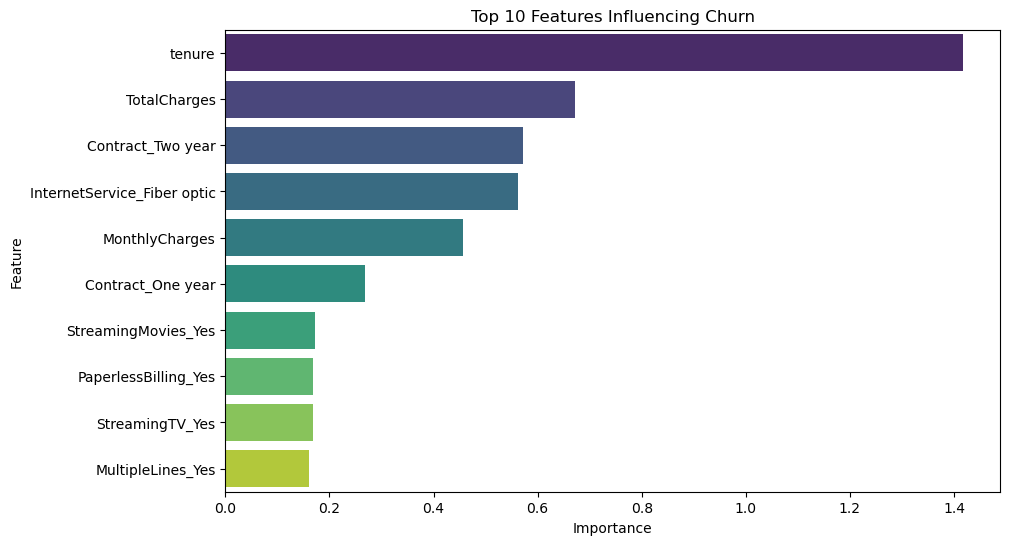

In [8]:
# Identify key factors influencing churn ---
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': model.coef_[0]
})
feature_importance['Importance'] = feature_importance['Coefficient'].abs()
feature_importance = feature_importance.sort_values(by='Importance', ascending=False)

print("Top 10 features influencing churn:")
print(feature_importance.head(10))

plt.figure(figsize=(10,6))
sns.barplot(x='Importance', y='Feature', hue='Feature' , data=feature_importance.head(10), palette='viridis')
plt.title('Top 10 Features Influencing Churn')
plt.show()

In [5]:
# Calculate Customer Lifetime Value (LTV) ---
df['LTV'] = df['MonthlyCharges'] * df['tenure']

print("\nTop 5 customers by LTV:")
print(df[['customerID', 'LTV']].sort_values(by='LTV', ascending=False).head())


Top 5 customers by LTV:
      customerID     LTV
4586  7569-NMZYQ  8550.0
6118  9924-JPRMC  8510.4
4610  2889-FPWRM  8481.6
3205  3810-DVDQQ  8467.2
6768  9739-JLPQJ  8460.0


In [6]:
# Predict churn probabilities and identify high-value customers at risk 
# Prepare encoded features and scale for churn probability prediction
X_all_scaled = scaler.transform(df_encoded.drop('Churn', axis=1))
df['Churn_Prob'] = model.predict_proba(X_all_scaled)[:,1]

# Threshold for at-risk customers (can adjust)
threshold = 0.5
high_risk = df[df['Churn_Prob'] > threshold]

# Sort high-risk customers by LTV descending
high_value_at_risk = high_risk.sort_values(by='LTV', ascending=False)

print("\nTop 10 high-value customers at risk of churn:")
print(high_value_at_risk[['customerID', 'LTV', 'Churn_Prob']].head(10))


Top 10 high-value customers at risk of churn:
      customerID      LTV  Churn_Prob
4074  0946-CLJTI  5724.60    0.520720
2075  7901-TBKJX  5658.80    0.524695
6009  6646-VRFOL  5504.05    0.525419
3411  7056-IMHCC  5400.70    0.531161
3910  8938-UMKPI  5000.80    0.527738
2474  5630-IXDXV  4998.45    0.507301
3330  8276-MQBYC  4987.80    0.558570
6342  3384-CTMSF  4892.70    0.531086
1663  5364-XYIRR  4827.15    0.502694
4264  8818-DOPVL  4804.70    0.583331


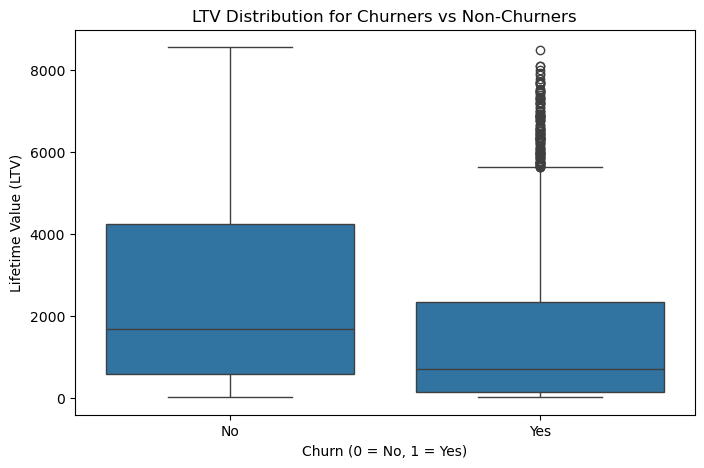

In [7]:
# Visualize distribution of LTV for churners vs non-churners ---
plt.figure(figsize=(8,5))
sns.boxplot(data=df, x='Churn', y='LTV')
plt.title('LTV Distribution for Churners vs Non-Churners')
plt.xlabel('Churn (0 = No, 1 = Yes)')
plt.ylabel('Lifetime Value (LTV)')
plt.show()